In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

**1. Загрузите файл HR.csv в pandas dataframe**

In [2]:
df = pd.read_csv('HR.csv')

**2. Рассчитайте основные статистики для переменных (среднее,медиана,мода,мин/макс,сред.отклонение)**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [12]:
# Перечисляю столбцы с числовым форматом, без булиевого типа:
columns = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']

# Записываю в переменную все данные из describe()
stats = df[columns].describe()

# Медиана
medians = df[columns].median()
# Мода
modes = df[columns].mode().iloc[0]  # Если есть несколько мод, выбираем первую из них

# Дополняю данные медианой и модой
stats.loc['median'] = medians
stats.loc['mode'] = modes

# Оставляю только то, что требуется по заданию
required_stats = stats.loc[['mean', 'median', 'mode', 'min', 'max', 'std']]

print(required_stats)


        satisfaction_level  last_evaluation  number_project  \
mean              0.612834         0.716102        3.803054   
median            0.640000         0.720000        4.000000   
mode              0.100000         0.550000        4.000000   
min               0.090000         0.360000        2.000000   
max               1.000000         1.000000        7.000000   
std               0.248631         0.171169        1.232592   

        average_montly_hours  time_spend_company  
mean              201.050337            3.498233  
median            200.000000            3.000000  
mode              135.000000            3.000000  
min                96.000000            2.000000  
max               310.000000           10.000000  
std                49.943099            1.460136  


**3. Рассчитайте и визуализируйте корреляционную матрицу для количественных переменных.**

**Определите две самые скоррелированные и две наименее
скоррелированные переменные.**

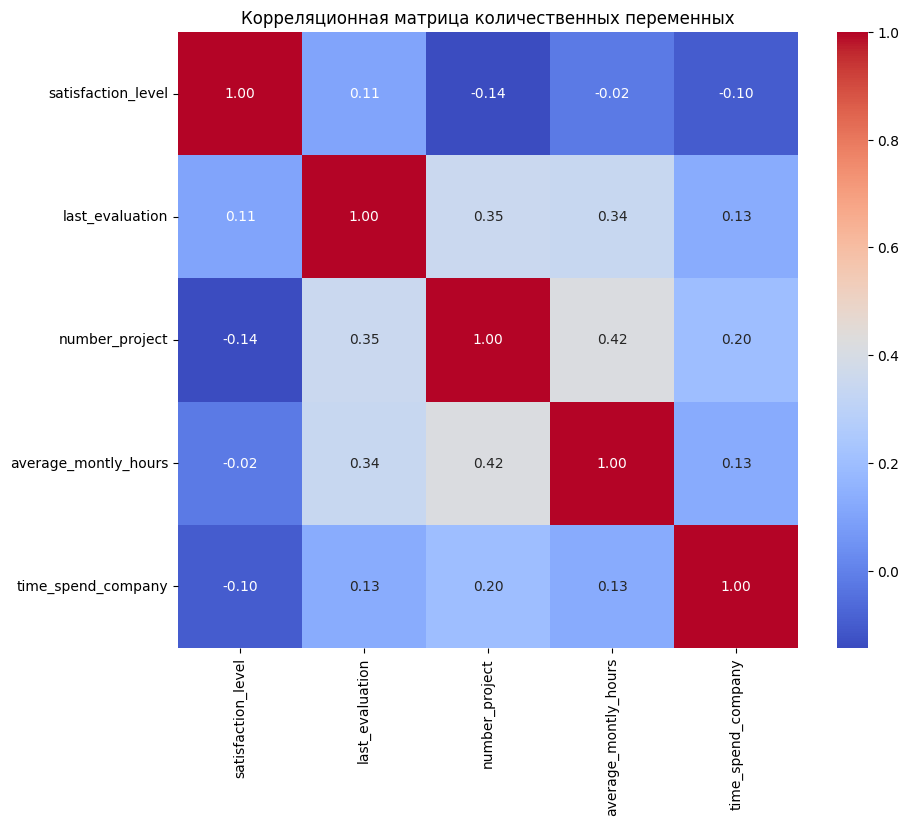

Две самые скоррелированные переменные:
number_project        average_montly_hours    0.417211
average_montly_hours  number_project          0.417211
dtype: float64

Две наименее скоррелированные переменные:
satisfaction_level    average_montly_hours    0.020048
average_montly_hours  satisfaction_level      0.020048
dtype: float64


In [16]:
# Перечисляю столбцы с числовым форматом, без булиевого типа:
numeric_variables = df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']]

# Рассчет корреляционной матрицы
correlation_matrix = numeric_variables.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица количественных переменных')
plt.show()

# Беру две переменные, у которых по модулю корреляция самая большая (кроме 1)
highest_correlations = correlation_matrix.unstack().abs().sort_values(ascending=False)
print("Две самые скоррелированные переменные:")
print(highest_correlations[highest_correlations != 1].head(2))

# Беру две переменные, у которых по модулю корреляция самая маленькая
lowest_correlations = correlation_matrix.unstack().abs().sort_values()
print("\nДве наименее скоррелированные переменные:")
print(lowest_correlations.head(2))

"Среднее количество часов на рабочем месте в месяц" и "Количество проектов, выполненных за время работы" больше всего коррелируют.

А "Уровень удовлетворенности работой" и "Среднее количество часов на рабочем месте в месяц" меньше всего коррелирует.

**4. Рассчитайте сколько сотрудников работает в каждом
департаменте.**

In [18]:
# Убираю тех, кто уволился
employees_remaining = df[df['left'] == 0]

# Считаю сколько работает в каждом департаменте
employee_count = employees_remaining['department'].value_counts()

print(employee_count)

department
sales          3126
technical      2023
support        1674
IT              954
product_mng     704
RandD           666
marketing       655
accounting      563
management      539
hr              524
Name: count, dtype: int64


**5. Показать распределение сотрудников по зарплатам**

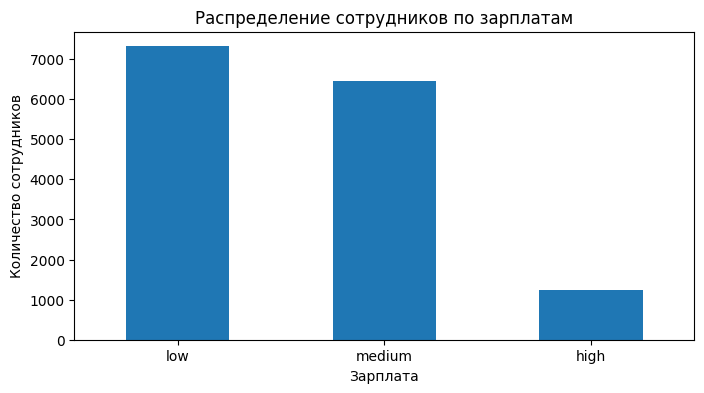

In [24]:
# Считаю количество на каждом уровне (не сказано, что работающих - беру всех осознанно)
salary_distribution = df['salary'].value_counts()

# Строю гистограмму
plt.figure(figsize=(8, 4))
salary_distribution.plot(kind='bar')
plt.title('Распределение сотрудников по зарплатам')
plt.xlabel('Зарплата')
plt.ylabel('Количество сотрудников')
plt.xticks(rotation=0)
plt.show()

**6. Показать распределение сотрудников по зарплатам в каждом департаменте по отдельности**

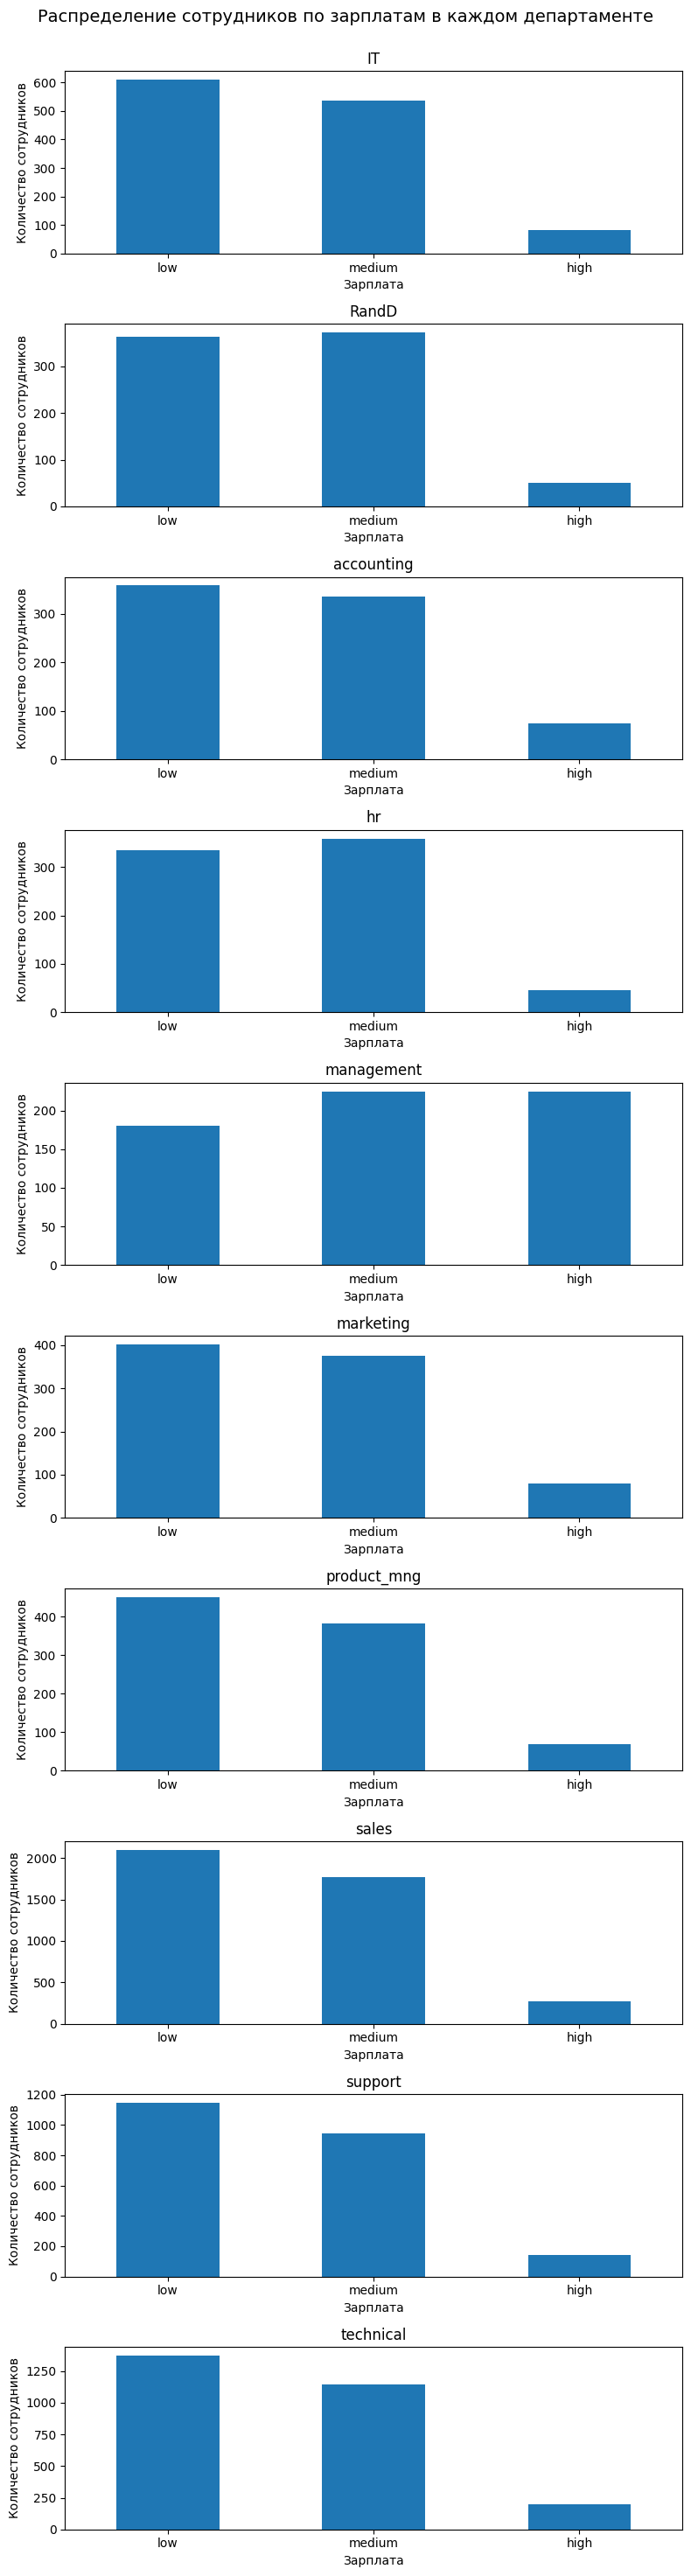

In [41]:
# Группирую данные и разбиваю по разным столбцам
salary_distribution_by_department = df.groupby(['department', 'salary']).size().unstack()

# Задаю порядок столбцов (иначе сбивается)
salary_distribution_by_department = salary_distribution_by_department.reindex(columns=['low', 'medium', 'high'])

# Строю много гистограмм: количество по количеству департаментов, друг под другом
fig, axes = plt.subplots(nrows=len(salary_distribution_by_department), ncols=1, figsize=(8, 30))

for i, (department, data) in enumerate(salary_distribution_by_department.iterrows()):
    data.plot(kind='bar', ax=axes[i])
    axes[i].set_title(department)
    axes[i].set_xlabel('Зарплата')
    axes[i].set_ylabel('Количество сотрудников')
    axes[i].tick_params(axis='x', rotation=0)

plt.suptitle('Распределение сотрудников по зарплатам в каждом департаменте', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Интересно, что у менеджеров ЗП стремятся к высоким, а у product manager-ов к низким. Обидно, на них ведь держится функционал, его улучшение.**

**7. Проверить гипотезу, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом**

In [48]:
# Создаю две выборки:
high_salary_hours = df[df['salary'] == 'high']['average_montly_hours']
low_salary_hours = df[df['salary'] == 'low']['average_montly_hours']

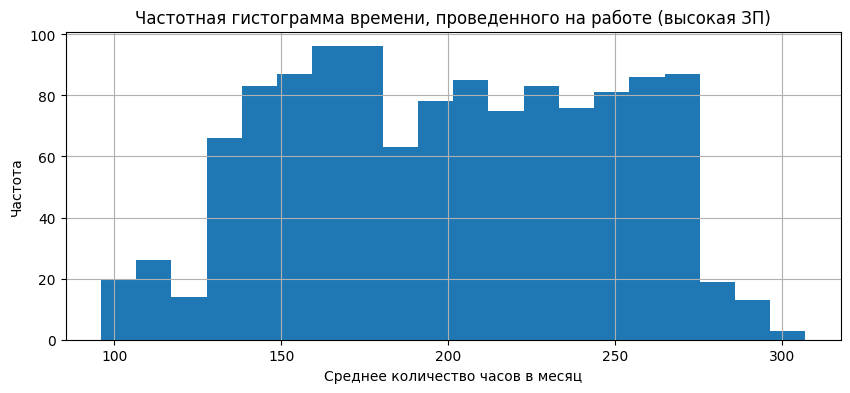

In [54]:
# Смотрю распределение:
plt.figure(figsize=(10, 4))
plt.hist(high_salary_hours, bins=20)
plt.title('Частотная гистограмма времени, проведенного на работе (высокая ЗП)')
plt.xlabel('Среднее количество часов в месяц')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

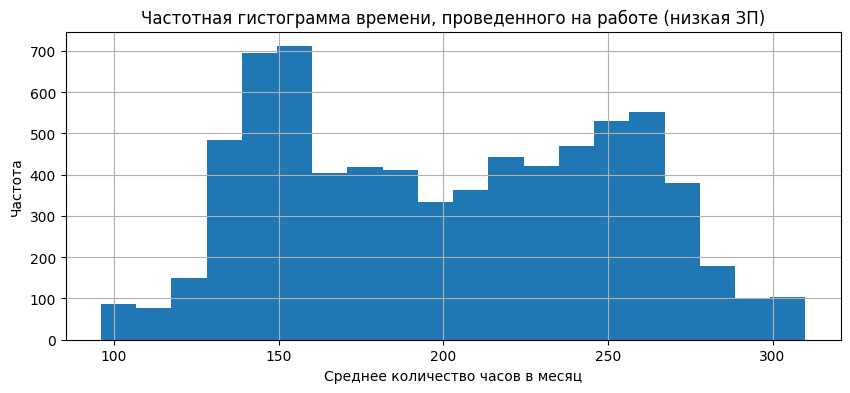

In [55]:
plt.figure(figsize=(10, 4))
plt.hist(low_salary_hours, bins=20)
plt.title('Частотная гистограмма времени, проведенного на работе (низкая ЗП)')
plt.xlabel('Среднее количество часов в месяц')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**На глаз распределение близко к нормальному. Двугорбое.**

In [56]:
# Применяю тест на нормальность распределения Шапиро:

statistic, p_value = shapiro(high_salary_hours)
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Распределение не является нормальным.")
else:
    print("Не отвергаем нулевую гипотезу. Распределение является нормальным.")

Отвергаем нулевую гипотезу. Распределение не является нормальным.


In [58]:
statistic, p_value = shapiro(low_salary_hours)
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Распределение не является нормальным.")
else:
    print("Не отвергаем нулевую гипотезу. Распределение является нормальным.")

Отвергаем нулевую гипотезу. Распределение не является нормальным.


**Тест Шапиро показал, что распределение не является нормальным.**

In [59]:
# Проверим, что с дисперсиями с помощью теста Левена:

statistic, p_value = levene(high_salary_hours, low_salary_hours)
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существуют статистически значимые различия в дисперсиях.")
else:
    print("Не отвергаем нулевую гипотезу. Нет статистически значимых различий в дисперсиях.")


Отвергаем нулевую гипотезу. Существуют статистически значимые различия в дисперсиях.


**Дисперсии неоднородны**

**Следовательно, выбираем статистический критерий Манна-Уитни:**

In [61]:
statistic, p_value = mannwhitneyu(high_salary_hours, low_salary_hours)
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Есть статистически значимая разница между временем, проведенным на работе, для сотрудников с высоким и низким окладом.")
else:
    print("Не отвергаем нулевую гипотезу. Нет статистически значимой разницы между временем, проведенным на работе, для сотрудников с высоким и низким окладом.")


Не отвергаем нулевую гипотезу. Нет статистически значимой разницы между временем, проведенным на работе, для сотрудников с высоким и низким окладом.


**Вывод: сотрудники с высоким окладом не обязательно проводят на работе больше времени, чем сотрудники с низким окладом.**

**8. Рассчитать следующие показатели среди уволившихся и не уволившихся сотрудников (по отдельности):**

- Доля сотрудников с повышением за последние 5 лет
- Средняя степень удовлетворенности
- Среднее количество проектов

In [62]:
# Доля сотрудников с повышением за последние 5 лет
# Так как мы находим среднее значение булиевого столбца, получается доля единиц:
promotion_percentage = df.groupby('left')['promotion_last_5years'].mean()

# Средняя степень удовлетворенности
satisfaction_mean = df.groupby('left')['satisfaction_level'].mean()

# Среднее количество проектов
projects_mean = df.groupby('left')['number_project'].mean()

# Вывод результатов
print("Среди уволившихся сотрудников:")
print("Доля сотрудников с повышением за последние 5 лет:", promotion_percentage[1])
print("Средняя степень удовлетворенности:", satisfaction_mean[1])
print("Среднее количество проектов:", projects_mean[1])
print("\nСреди не уволившихся сотрудников:")
print("Доля сотрудников с повышением за последние 5 лет:", promotion_percentage[0])
print("Средняя степень удовлетворенности:", satisfaction_mean[0])
print("Среднее количество проектов:", projects_mean[0])

Среди уволившихся сотрудников:
Доля сотрудников с повышением за последние 5 лет: 0.005320638476617194
Средняя степень удовлетворенности: 0.44009801176141133
Среднее количество проектов: 3.8555026603192384

Среди не уволившихся сотрудников:
Доля сотрудников с повышением за последние 5 лет: 0.026251312565628283
Средняя степень удовлетворенности: 0.666809590479524
Среднее количество проектов: 3.786664333216661


**Видим, что среди не уволившихся сотрудников всего на 2% больше получали повышение за последние 5 лет.**

**Зато степень удовлетворенности значительно выше у неуволившихся.**

**Проектов приблизительно одинаково.**

**9. Разделить данные на тестовую и обучающую выборки. Построить модель LDA, предсказывающую уволился ли сотрудник на основе имеющихся факторов (кроме department и salary)**

**Оценить качество модели на тестовой выборке.**

In [71]:
# создаю копию, мне так проще работать:
df_copy = df.copy()

# удаляю ненужные факторы (нечисловые):
df_copy.drop(['department', 'salary'], axis=1, inplace=True)

# делю на признаки (всё кроме увольнения), и на целевую переменную:
X = df_copy.drop('left', axis=1)
y = df_copy['left']

# делю на тестовую и обучающую выборки:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# модель LDA:
lda = LinearDiscriminantAnalysis()

# обучаю модель:
lda.fit(X_train, y_train)

# предсказываю значения на тестовой выборке:
y_pred = lda.predict(X_test)

# оцениваю качество модели:
accuracy = accuracy_score(y_test, y_pred)
print("Оценка качества модели:", accuracy)

Оценка качества модели: 0.7533333333333333


**Примерно 75.33% случаев классифицируются верно.**